# Analysis of Oscillations

# Preliminaries

## Imports

In [1]:
import tellurium as te
import sympy
import matplotlib.pyplot as plt
import numpy as np
import os

from common_python.sympy import sympyUtil as su
from common_python.ODEModel.ODEModel import ODEModel
from common_python.ODEModel.oscillationFinder import OscillationFinder, XDict
import matplotlib.pyplot as plt

## Constants

In [2]:
su.addSymbols("S0 S1 S2 S3 S4 S5 S6 S7 S8 S9 k0 k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12 k13 k14 k15 k16 k17 k18 k19 k20")
su.addSymbols("J0 J1 J2 J3 J4 J5 J6 J7 J8 J9 J10 J11 J12 J13 J14 J15 J16 J`7 J18 J19 J20")
FLUXES = [J0, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13, J14, J15]
SPECIES = [S0, S1, S2, S3, S4, S5, S6, S7, S8]
MODEL_DIR = "/home/ubuntu/ComplexSystems/models/3-state"

In [3]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = 6+0.9011095014634776
k5 = 1.4823891153952284
k6 = -10+15.149868787476994
k9 = 91.19197034598812
k10 = 200
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
"""
RR = te.loada(MODEL)

# Helper Functions

In [4]:
# Create dictionary relating reaction names to species
def mkStoichiometryExpressionDct(rr):
    stoichiometryArr = rr.getFullStoichiometryMatrix()
    reactionNames = [n[1:] if n[0] == "_" else n for n in stoichiometryArr.colnames]
    stoichiometryArr.colnames = reactionNames
    speciesNames = stoichiometryArr.rownames
    dct = {}
    for idx, species in enumerate(speciesNames):
        sym = eval(species)
        entry = ["%d*%s" % (stoichiometryArr[idx, n], reactionNames[n]) for n in range(len(reactionNames))]
        expressionStr = " + ".join(entry)
        dct[sym] = eval(expressionStr)
        dct[sym] = sympy.simplify(dct[sym])
    return dct

# Tests
stoichiometryDct = mkStoichiometryExpressionDct(RR)
stoichiometryDct  

{S0: -J0 + J1, S2: J0 - J2, S3: -2*J1 + J2 - J3 + J4}

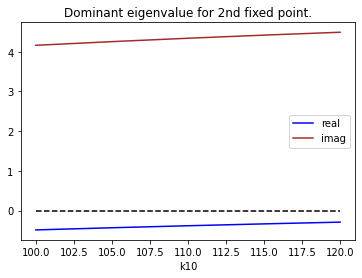

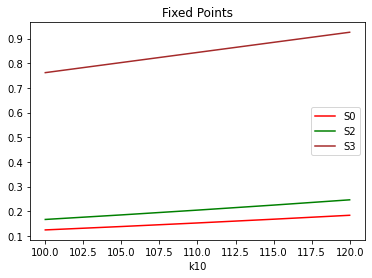

In [5]:
# Do plot
def plotEigenInfo(rr, title="", k10Range=None, fixedPointIdx=1, **kwargs):
    """
    Plots information about the dominant eigenvalue and fixed point for the
    indicated fixed point.
    
    Parameters
    ----------
    rr: ExtendedRoadrunner
    title: str
    k10Range: range of k10
    fixedPointIdx: int
        index of the fixed point to study
    kwargs: dict
        fractional adjustment in value
    """
    if k10Range is None:
        k10Range = [150 + v for v in range(60)]
    # Construct the data
    subDct = {k0: rr.k0, k5: rr.k5, k6: rr.k6, k9: rr.k9, k10: rr.k10}
    for key, value in kwargs.items():
        if isinstance(key, str):
            newKey = [s for s in subDct.keys() if s.name == key][0]
        else:
            newKey = key
        subDct[newKey] = subDct[newKey] * value
    xvs = []
    reals = []
    imags = []
    fixedPointDcts = []
    for c10 in k10Range: 
        subDct[k10] = c10
        dominantReal = None
        dominantImag = None
        modelInfo = ODEModel.mkODEModel(rr, subs=subDct, isEigenvecs=False)
        model = modelInfo.mdl
        #model = ODEModel(REDUCED_STATE_DCT, subs=subDct, isEigenvecs=False)
        # Find the dominant eigenvalue for the fixed points
        if len(model.fixedPoints) > fixedPointIdx:
            fixedPointDcts.append(dict(model.fixedPoints[fixedPointIdx].valueDct))
            # Find the dominant eigenvalue
            for entry in model.fixedPoints[fixedPointIdx].eigenEntries:
                value = entry.value
                if isinstance(value, complex):
                    real, imag = su.asRealImag(value)
                else:
                    real = value
                    imag = 0
                if (dominantReal is None) or (real > dominantReal):
                    dominantReal = real
                    dominantImag = np.abs(imag)
        xvs.append(c10)
        reals.append(dominantReal)
        imags.append(dominantImag)
    # Plot the dominant eigenvalue
    _, ax = plt.subplots(1)
    ax.plot(xvs, reals, color="blue")
    ax.plot(xvs, imags, color="brown")
    ax.plot([xvs[0], xvs[-1]], [0, 0], linestyle="--", color="black")
    ax.legend(["real", "imag"])
    ax.set_title(title)
    ax.set_xlabel("k10")
    # Plot the indexed fixed point
    states = list(fixedPointDcts[0].keys())
    _, ax = plt.subplots(1)
    COLORS = ["red", "green", "brown"]
    for idx, state in enumerate(states):
        yvs = [f[state] for f in fixedPointDcts]
        ax.plot(xvs, yvs, color=COLORS[idx])
    ax.legend(states)
    ax.set_title("Fixed Points")
    ax.set_xlabel("k10")
    return fixedPointDcts
    
# Test
dcts = plotEigenInfo(RR, k10Range=[100 + 5*v for v in range(5)], k9=1, title="Dominant eigenvalue for 2nd fixed point.")

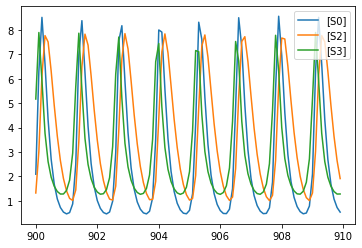

In [6]:
def runSim(model=MODEL, endTime=100, startTime=0, **kwargs):
    def findIdx(arr, time):
        """Finds the index of the time in the simulation results array."""
        bestIdx = 0
        diff = np.abs(arr[0, 0] - time)
        for idx, value in enumerate(arr[:, 0]):
            if np.abs(value - time) < diff:
                diff = np.abs(value - time)
                bestIdx = idx
        return bestIdx
    rr = te.loada(MODEL)
    # Adjust the parameters
    for key, value in kwargs.items():
        if isinstance(key, sympy.core.symbol.Symbol):
            newKey = s.name
        else:
            newKey = key
        rr[newKey] = rr[newKey] * value
    #rr.plot(rr.simulate(startTime, endTime, 10*endTime))
    arr = rr.simulate(0, endTime, 10*endTime)
    _, ax = plt.subplots(1)
    startIdx = findIdx(arr, startTime)
    endIdx = findIdx(arr, endTime)
    for idx in range(len(arr.colnames[1:])):
        ax.plot(arr[startIdx:endIdx,0], arr[startIdx:endIdx, idx+1])
    ax.legend(arr.colnames[1:])
    
# Tests
runSim(k9=0.5, startTime=900, endTime=910)

# Numercial Evaluations

Analyzes the eigenvalues numerically for the antimony simulation model

In [7]:
files = [os.path.join(MODEL_DIR, f) for f in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, f))]
files

['/home/ubuntu/ComplexSystems/models/3-state/Model_8570403923242184953.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_308756242966137270.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_1179159900924707683.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_495895561502583999.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_504265579707051998.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_7767344276012911592.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_191588763966222966.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_5596570675878850909.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_8734971625908708850.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_2039186835123380747.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_118483669170045219.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_6648256619537599386.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_5692220670942502751.ant',
 '/h

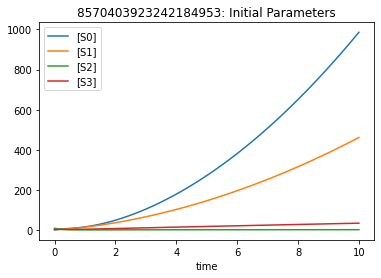

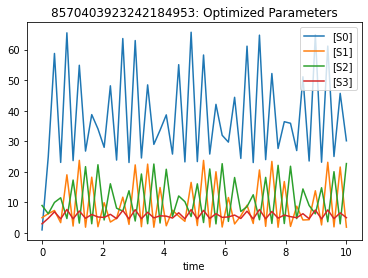

In [11]:
def analyzeFile(path, **kwargs):
    def mkTitle(string):
        start = path.index("Model_") + len("Model_")
        end = path.index(".ant")
        prefix = path[start:end]
        return "%s: %s" % (prefix, string)
    #
    rr = te.loada(path)
    finder = OscillationFinder(rr)
    # Change the parameter values
    initialParameterXD = XDict.mkParameters(rr)
    initialParameterXD = XDict(initialParameterXD.keys(), 1)
    # finder.setParameters(initialParameterXD)
    finder.simulate(parameterXD=initialParameterXD)
    finder.plot(title=mkTitle("Initial Parameters"))
    # Find the parameters
    feasibleParameterXD = finder.find(**kwargs)
    finder.simulate(parameterXD=feasibleParameterXD)
    finder.plot(title=mkTitle("Optimized Parameters"))
    return feasibleParameterXD
    

# Tests
parameterXD = analyzeFile(files[0])


In [ ]:
for ffile in files:
    analyzeFile(ffile)

In [9]:
STOP

NameError: name 'STOP' is not defined

# Damped Model 2

In [ ]:
MODEL2 = """
var S0
var S1
var S2
var S3
var S4
var S5
var S6
var S7
ext S8
J0: S4 -> S7+S5; k0*S4
J1: S2 -> S4+S4; k1*S2
J2: S4 -> S3+S3; k2*S4
J3: S4 -> S2+S3; k3*S4
J4: S0 -> S5; k4*S0
J5: S5 + S4 -> S5; k5*S5*S4
J6: S5 -> S3; k6*S5
J7: S8 + S3 -> S0; k7*S8*S3
J8: S3 -> S6+S5; k8*S3
J9: S6 + S5 -> S4; k9*S6*S5
J10: S7 + S5 -> S0 + S2; k10*S7*S5
J11: S3 -> S5+S6; k11*S3
J12: S6 + S1 -> S5; k12*S6*S1
J13: S5 -> S5; k13*S5
J14: S1 + S7 -> S1 + S1; k14*S1*S7
k0 = 2.5920480618068815
k1 = 422.2728070204247
k2 = 28.978192374985912
k3 = 29.723263589242986
k4 = 21.04114996098882
k5 = 1.5111236529181926
k6 = 14.363185343334044
k7 = 0.8231126169112812
k8 = 54.27226867691914
k9 = 58.17954213283633
k10 = 10.682986014127339
k11 = 194.08273474192015
k12 = 15.989508525207631
k13 = 13.186614071108659
k14 = 35.67582901156382
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
S5 = 3.0
S6 = 7.0
S7 = 1.0
S8 = 6.0
"""

rr = te.loada(MODEL2)
rr.plot(rr.simulate())

In [ ]:
mat = sympy.Matrix(rr.getFullStoichiometryMatrix())
mat

In [ ]:
SPECIES_FLUX_DCT = mkStoichiometryExpressionDct(rr)
SPECIES_FLUX_DCT

In [ ]:
nullspace = mat.nullspace()

In [ ]:
# Kinetics dictionary
kineticDct = {
    J0:  k0*S4,
    J1:  k1*S2,
    J2:  k2*S4,
    J3:  k3*S4,
    J4:  k4*S0,
    J5:  k5*S5*S4,
    J6:  k6*S5,
    J7:  k7*S8*S3,
    J8:  k8*S3,
    J9:  k9*S6*S5,
    J10:  k10*S7*S5,
    J11:  k11*S3,
    J12:  k12*S6*S1,
    J13:  k13*S5,
    J14:  k14*S1*S7,
}

In [ ]:
modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)

In [ ]:
# Note that S8 is external and so is constant
modelInfo.mdl.stateDct

In [ ]:
STATE_DCT = {s: SPECIES_FLUX_DCT[s].subs(kineticDct) for s in SPECIES_FLUX_DCT.keys() }
STATE_DCT

In [ ]:
relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)
mat = sympy.simplify(relaxationResult.mat)
mat

In [ ]:
relaxationResult.sub

In [ ]:
bVec = sympy.zeros(relaxationResult.mat.rows, 1)
nullResult = relaxationResult.mat.gauss_jordan_solve(bVec)

In [ ]:
nullResult[1]

In [ ]:
nullVec = nullResult[0]

In [ ]:
# Construct the constraints

In [ ]:
nullResult[0][1] * nullResult[0][6], nullResult[0][8]

In [ ]:
nullResult[0][4]

In [ ]:
nullResult[0][5]

In [ ]:
nullResult[0][10]

In [ ]:
MODEL = ODEModel(STATE_DCT, isFixedPoints=False)

In [ ]:
# Need to find a linear combination of values in the null space
# such that the kinetic equations hold.
# Have N reactions, M species. So, N - M constants to find.
su.addSymbols("c c_0 c_1 c_2 c_3 c_4 c_5 c_6")
c = sympy.Matrix([c_0, c_1, c_2, c_3, c_4, c_5, c_6])
mat = sympy.Matrix(nullspace).reshape(15, 7)
mat * c

In [ ]:
105/7

In [ ]:
# Solve for log(S*)
exprs = [ j - b for j, b in zip(kineticDct.values(), mat*c) ]
exprs = [e.subs({S2: 0, S3: 0}) for e in exprs]
sympy.solve(exprs, [ S5])

**Approach**
1. $N$ =  stoichiometry matrix
1. $M$ = nullspace of $N$
1. Substitute 0 for any state variable that must be zero for all vectors $M \star c$.
1. Solve for log of $x_n$ (state variable) in terms of log of $J_n$ (fluxes)
1. We know that the fluxes for the fixed points must be in $M \star c$, where $c$ is a vector.
1. Substitute $J_n$ value from previous (5) into (4) to give an expression for $x_n$ in terms of $c_n$.

Issue: How do I find the $c_i$?

**Approach 2**
1. Solve for $x_n$ in terms of $J$

In [ ]:
# Looks like I can manually solve for most species
SPECIES_FLUX_DCT = {
    S0: J4/k4,
    S1: (J12/k12) /((J9 / k9) / (J6 / k6)),
    S2: J1 / k1,
    S3: J8 / k8,
    S4: J0 / k0,
    S5: J6 / k6,
    S6: (J9 / k9) / (J6 / k6),
    S7: (J10 / k10) / (J6 / k6),
    S8: (J7 / k7) / (J8 / k8),   
    
}

In [ ]:
dstateDct =  {s: SPECIES_FLUX_DCT[s].subs(kineticDct) for s in SPECIES_FLUX_DCT.keys()}

In [ ]:
dstateDct

# Reduced Model

In [ ]:
su.addSymbols("S0 S1 S2 S3 S4 S5 S6")
su.addSymbols("k0 k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12 k13 k14 k15 k16 k17 k18 k19 k20")
su.addSymbols("J0 J1 J2 J3 J4 J5 J6 J7 J8 J9 J10 J11 J12 J13 J14 J15 J16 J`7 J18 J19 J20")
REDUCED_FLUXES = [J0, J1, J2, J3, J4]
REDUCED_SPECIES = [S0, S1, S2, S3, S4]

In [ ]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = 6+0.9011095014634776
k5 = 1.4823891153952284
k6 = -10+15.149868787476994
k9 = 91.19197034598812
k10 = 200
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
"""

In [ ]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = (6+0.9011095014634776)
k5 = 1.4823891153952284
k6 = (-10+15.149868787476994)
k9 = 91.19197034598812  # At k9 * 0.5, use k10 = k155
k10 = 200 # 164, 165 ins a transition from damped to stable oscillations
S0 = 1.0
S2 = 9.0
S3 = 3.0
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate(0, 100, 100)) 

In [ ]:
runSim(k9=0.5, k10=140, endTime=1000)

In [ ]:
runSim(k9=0.5, k10=150, endTime=1000)

## Relaxation Analysis

1. Create a linear system by adding new variables for quadratics.
1. Find the nullspace of the linear system.
1. Solve for unknown constants using constraints.

In [ ]:
modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)

In [ ]:
modelInfo.mdl.stateDct

In [ ]:
relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)
mat = sympy.simplify(relaxationResult.mat)
mat

In [ ]:
nullVecs = mat.nullspace(relaxationResult.vec)
nullVecs

In [ ]:
relaxationResult.vec

In [ ]:
su.addSymbols("c_0 c_1")
nullVec = nullVecs[0]*c_0 + nullVecs[1] * c_1
nullVec

In [ ]:
# Solve for the constraints
# Constraint 1: S2*S3 == S2S3
sympy.solve(nullVec[1] * nullVec[2] -   nullVec[3], [c_0, c_1])

In [ ]:
# Solve for the constraints
# Constraint 2: S3*S3 == S3S3
sympy.solve(nullVec[2] * nullVec[2] -   nullVec[4], [c_0, c_1])

So, $c_0 = k_6 \frac{-k_0 + k_{10}}{k_0 k_9}$. $c_1 = c_0^2$.

In [ ]:
# Verifying the solution
newNullVec = nullVec.subs(c_1, c_0**2)
newNullVec = newNullVec.subs(c_0, -k6*(k10-k0)/(k0*k9))
newNullVec

### Algorithm

In [ ]:
# Create the state equations from the roadrunner model
def findFixedPoints(rr):
    """
    Finds the fixed points of the roadrunner model that only has mass action kinetics
    and no more than two reactants. The approach uses relaxation by transforming the quadratic
    equations to a higher dimension linear space.
    
    Parameteters
    ------------
    rr: ExtendedRoadRunner
    
    Returns
    -------
    list-dict
        key: state variable symbol
        value: expressions
    """
    def findIdx(sym):
        return list(relaxationResult.vec).index(sym)
    #
    modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)
    relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)
    mat = sympy.simplify(relaxationResult.mat)
    nullVecs = mat.nullspace(relaxationResult.vec)
    # Create solution for the nullspace
    constantStrs = ["c%d" % n for n in range(len(nullVecs))]
    su.addSymbols(" ".join(constantStrs), dct=globals())
    constantSyms = [globals()[s] for s in constantStrs]
    mat =  sympy.Matrix(nullVecs)
    numRow = nullVecs[0].rows
    numCol = len(nullVecs)
    nullspaceLst = [list(v) for v in nullVecs]
    mat = sympy.Matrix(nullspaceLst)
    mat = mat.transpose()
    constantVec = sympy.Matrix(constantSyms)
    nullspaceVec = mat * constantVec
    # Solve for the constraints
    symEntryDct = {s: nullspaceVec[n] for n, s in enumerate(relaxationResult.vec)}
    # Construct equality expressions and solve.
    eprs = []
    for quadSym, quadEpr in relaxationResult.sub.items():
        quadIdx = findIdx(quadSym)
        syms = list(quadEpr.args)
        if syms[1] == 2:
            syms[1] = syms[0]
        symIdxs = [findIdx(s) for s in syms]
        prodEpr = nullspaceVec[symIdxs[0]] * nullspaceVec[symIdxs[1]]
        eprs.append(nullspaceVec[quadIdx] - prodEpr)
    return eprs, constantSyms
    solutions = sympy.solve(eprs, constantSyms) # Values of constants to match constraints
    # Calculate the fixed points
    simpleSyms = set(relaxationResult.vec).symmetric_difference(relaxationResult.sub.keys())
    simpleSyms = sorted(simpleSyms, key=lambda s: s.name)
    fixedPointDcts = []
    for solution in solutions:
        # Calculate the vector for each solution
        numVec = len(nullspaceLst)
        vec = sympy.zeros(len(relaxationResult.vec), 1)
        for idx in range(numVec):
            vec += solution[idx] * sympy.Matrix(nullspaceLst[idx])
        # Create the fixed point from the vector
        fixedPointDcts.append({simpleSyms[n]: vec[n] for n in range(len(simpleSyms))})
    return fixedPointDcts

# Tests
fixedPointDcts = findFixedPoints(rr)
fixedPointDcts

In [ ]:
fixedPointDcts[1][S3]

### Evaluation

In [ ]:
files = [os.path.join(MODEL_DIR, f) for f in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, f))]
files

In [ ]:
rr = te.loada(files[0])
print(rr.getAntimony())

In [ ]:
rr = te.loada(files[0])
result = findFixedPoints(rr)
if False:
    modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)
    relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)

In [ ]:
len(result[0])

In [ ]:
result[0][0].expand()

In [ ]:
result[0][1].expand()

In [ ]:
result[0][2]

In [ ]:
sympy.fraction(1)

In [ ]:
sympy.fraction(result[0][2].expand().args[1])

In [ ]:
modelInfo.mdl.stateDct

## Miscellaneous Analysis

In [ ]:
plot1(k0=0.01, k5=0.1, k6=0.1, k9=0.1, base=100)

In [ ]:
REDUCED_SPECIES_FLUX_DCT = mkStoichiometryExpressionDct(rr)
REDUCED_SPECIES_FLUX_DCT

In [ ]:
kineticDct = {
    J0: k0 * S0,
    J1: k5 * S3 * S3,
    J2: k6 * S2,
    J3: k9 * S2 * S3,
    J4: k10*S0,  # Is this really mass action?
    
}

In [ ]:
# State equation is wrong for S2. Should be - S2*k6
REDUCED_STATE_DCT = {s: REDUCED_SPECIES_FLUX_DCT[s].subs(kineticDct) for s in REDUCED_SPECIES_FLUX_DCT.keys()}
REDUCED_STATE_DCT

In [ ]:
sympy.solve(list(REDUCED_STATE_DCT.values()), list(REDUCED_STATE_DCT.keys()))

In [ ]:
reducedModel = ODEModel(REDUCED_STATE_DCT)

In [ ]:
# Fixed points
[f.valueDct for f in reducedModel.fixedPoints]

In [ ]:
# Verify that these are fixed points
for fp in reducedModel.fixedPoints:
    print([sympy.simplify(e.subs(fp.valueDct)) for e in REDUCED_STATE_DCT.values()])

In [ ]:
# Look at the eigenvectors
if False:
    for entry in reducedModel.fixedPoints[1].eigenEntries:
        for vector in entry.vectors:
            print(vector)

In [ ]:
eigenvalues = [e.value for e in reducedModel.fixedPoints[1].eigenEntries]

**Approach**
1. Find the fixed points.
1. For non-zero fixed points:
    1. Find the eigenvalues in terms of each constant in turn, setting the other constants to 1.
    1. Search for values of constants that result in a positive but near zero real value and significant non-zero imaginary part

**Issue**
1. Eigenvalues have no relationship to the system behavior

## Finding Parameter Values

Given an ODEModel, find values of parameters that result in oscillations at different frequencies.

In [ ]:
c0 = rr.k0
c5 = rr.k5
c6 = rr.k6
c9 = rr.k9
c10 = rr.k10
for c10 in [150 + n for n in range(50)]:
    subDct = {k0: c0, k5: c5, k6: c6, k9: c9, k10: c10}
    model = ODEModel(REDUCED_STATE_DCT, subs=subDct)
    entries = model.fixedPoints[1].eigenEntries
    print((c10, [e.value for e in entries]))

## Plots

In [ ]:
dcts = plotEigenInfo(RR, k10Range=[100 + 5*v for v in range(25)], k9=1, title="Dominant eigenvalue for 2nd fixed point.")

In [ ]:
runSim(k10=100/200, startTime=0, endTime=10)

In [ ]:
runSim(k10=160/200, startTime=0, endTime=10)

In [ ]:
runSim(k9=1, k10=160/200, startTime=990, endTime=1000)

In [ ]:
runSim(k9=1, k10=170/200, startTime=990, endTime=1000)

In [ ]:
runSim(k9=1, k10=200/200, startTime=990, endTime=1000)

In [ ]:
4.5 / (2*np.pi)

In [ ]:
def plot1(base=150, **kwargs):
    k10Range=[base + 10*v for v in range(10)]
    title = ""
    for key, value in kwargs.items():
        title += " %s: %3.2f " % (str(key), value)
    plotComplexEigenvalue(rr, k10Range=k10Range, title=title, **kwargs)
    
plot1(k0=1, k5=1, k6=1, k9=1)

In [ ]:
plot1(k0=0.01, k5=0.1, k6=0.1, k9=0.1, base=100)

In [ ]:
plot1(k0=1, k5=1, k6=1, k9=0.5, base=100)


In [ ]:
runSim(k0=1, k5=1, k6=1, k9=0.5, k10=100, endTime=1000)

Am i excluding the dominant eigenvalue? Do the plots for all eigenvalues.